In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

JAK_INHIBITORS = False

data_dir = "../data/09182025_IF_scan"
if_data_files = ["Cell.csv"]

columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]

column_to_stain = dict(zip(range(1,13), ["pSTAT"]*6 + ["tSTAT"] * 6))
column_to_stain = dict(zip(range(1,13), ["pSTAT"]*12))
column_to_stain = dict(zip(range(1,13), ["Fedra"]*6 + ["Filgo"]*6))

row_to_patient = {
    "A":813,
	"B":813,
	"C":826,
	"D":826,
	"E":904,
	"F":905,
	"G":905,
	#"H":617
}	

column_to_t_pts = {
	1:"0",
    2:"0",
	3:"0.01",
	4:"0.1",
	5:"0.33",
	6:"1",
	7:"0",
    8:"0",
	9:"0.1",
	10:"0.33",
	11:"1",
	12:"3.33"
}

row_to_replicate = {
    "A":1,
    "B":2,
    "C":1,
    "D":2,
    "E":1,
    "F":1,
    "G":2,
    #"H":1    
}
if JAK_INHIBITORS:
	column_to_row = {
		"A":"Control",
		"B":"Control",
		"C":"0.01nM Fedratinib",
		"D":"0.1nM Fedratinib",
		"E":"0.33nM Fedratinib",
		"F":"10nM Fedratinib",
		"G":"1nM Filgotinib",
		"H":"10nM Filgotinib"
	}


In [14]:
dfs = []
for fname in if_data_files:
	full_fname = f"{data_dir}/{fname}"
	df = pd.read_csv(full_fname, usecols=columns)

	stat1_means = df.groupby("WellId")["CircTotalIntenCh2"].mean()
	stat1_sems = df.groupby("WellId")["CircTotalIntenCh2"].std()
	stat3_means = df.groupby("WellId")["CircTotalIntenCh3"].mean()
	stat3_sems = df.groupby("WellId")["CircTotalIntenCh3"].std()

	stat_df = pd.concat([stat1_means, stat1_sems, stat3_means, stat3_sems], axis=1)
	stat_df.columns = ["STAT1 Mean", "STAT1 SEM", "STAT3 Mean", "STAT3 SEM"]
	stat_df.index = [x.strip() for x in stat_df.index]
	# Assign various characteristics based on wells using the dictionaries above
	rows = [x.strip()[0] for x in stat_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_df.index.values]
	stat_df["STAT"] = [column_to_stain[x] for x in cols]
	stat_df["PatientId"] = [row_to_patient[x] for x in rows]
	stat_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_df["Time"] = [column_to_t_pts[x] for x in cols]
	stat_df["Replicate"] = [row_to_replicate[x] for x in rows]
	if JAK_INHIBITORS:
		stat_df["JAK Inhibitor"] = [drug_to_row[x] for x in rows]
		stat_df["Column"] = cols
		stat_df.loc[[f"C0{i}" for i in [3,4,5,6]], "JAK Inhibitor"] = "1nM Fedratinib"
		stat_df.loc[[f"C{i:02d}" for i in [7,8,9,10]], "JAK Inhibitor"] = "10nM Fedratinib"
	stat_df["Date"] = data_dir.split("/")[-1]
	display(stat_df)
	stat_df.to_csv(f"{data_dir.split('/')[-1]}.csv")
	dfs.append(stat_df)

,STAT1 Mean,STAT1 SEM,STAT3 Mean,STAT3 SEM,STAT,PatientId,IL-6 Concentration,Time,Replicate,Date
A01,6.711064e+06,4.439236e+06,5.685091e+06,4.951131e+06,Fedra,813,10 ng/mL,0,1,09182025_IF_scan
A02,1.109546e+07,7.689880e+06,9.948857e+06,7.642550e+06,Fedra,813,10 ng/mL,0,1,09182025_IF_scan
A03,7.014542e+06,5.746078e+06,6.598611e+06,7.106622e+06,Fedra,813,10 ng/mL,0.01,1,09182025_IF_scan
A04,4.724635e+06,2.397067e+06,2.721295e+06,2.312430e+06,Fedra,813,10 ng/mL,0.1,1,09182025_IF_scan
A05,4.370846e+06,2.381619e+06,1.896867e+06,1.355133e+06,Fedra,813,10 ng/mL,0.33,1,09182025_IF_scan
...,...,...,...,...,...,...,...,...,...,...
G08,5.079500e+06,1.368897e+06,3.582928e+06,1.464147e+06,Filgo,905,10 ng/mL,0,2,09182025_IF_scan
G09,8.883229e+06,4.878974e+06,8.709493e+06,5.243161e+06,Filgo,905,10 ng/mL,0.1,2,09182025_IF_scan
G10,6.329932e+06,2.623769e+06,6.331410e+06,4.265574e+06,Filgo,905,10 ng/mL,0.33,2,09182025_IF_scan
G11,5.215255e+06,1.619471e+06,2.971685e+06,1.740052e+06,Filgo,905,10 ng/mL,1,2,09182025_IF_scan


Patient 813, Rep 1
Patient 813, Rep 2
Patient 826, Rep 1
Patient 826, Rep 2
Patient 904, Rep 1
Patient 905, Rep 1
Patient 905, Rep 2


Text(0.5, 0.98, 'Patient 905')

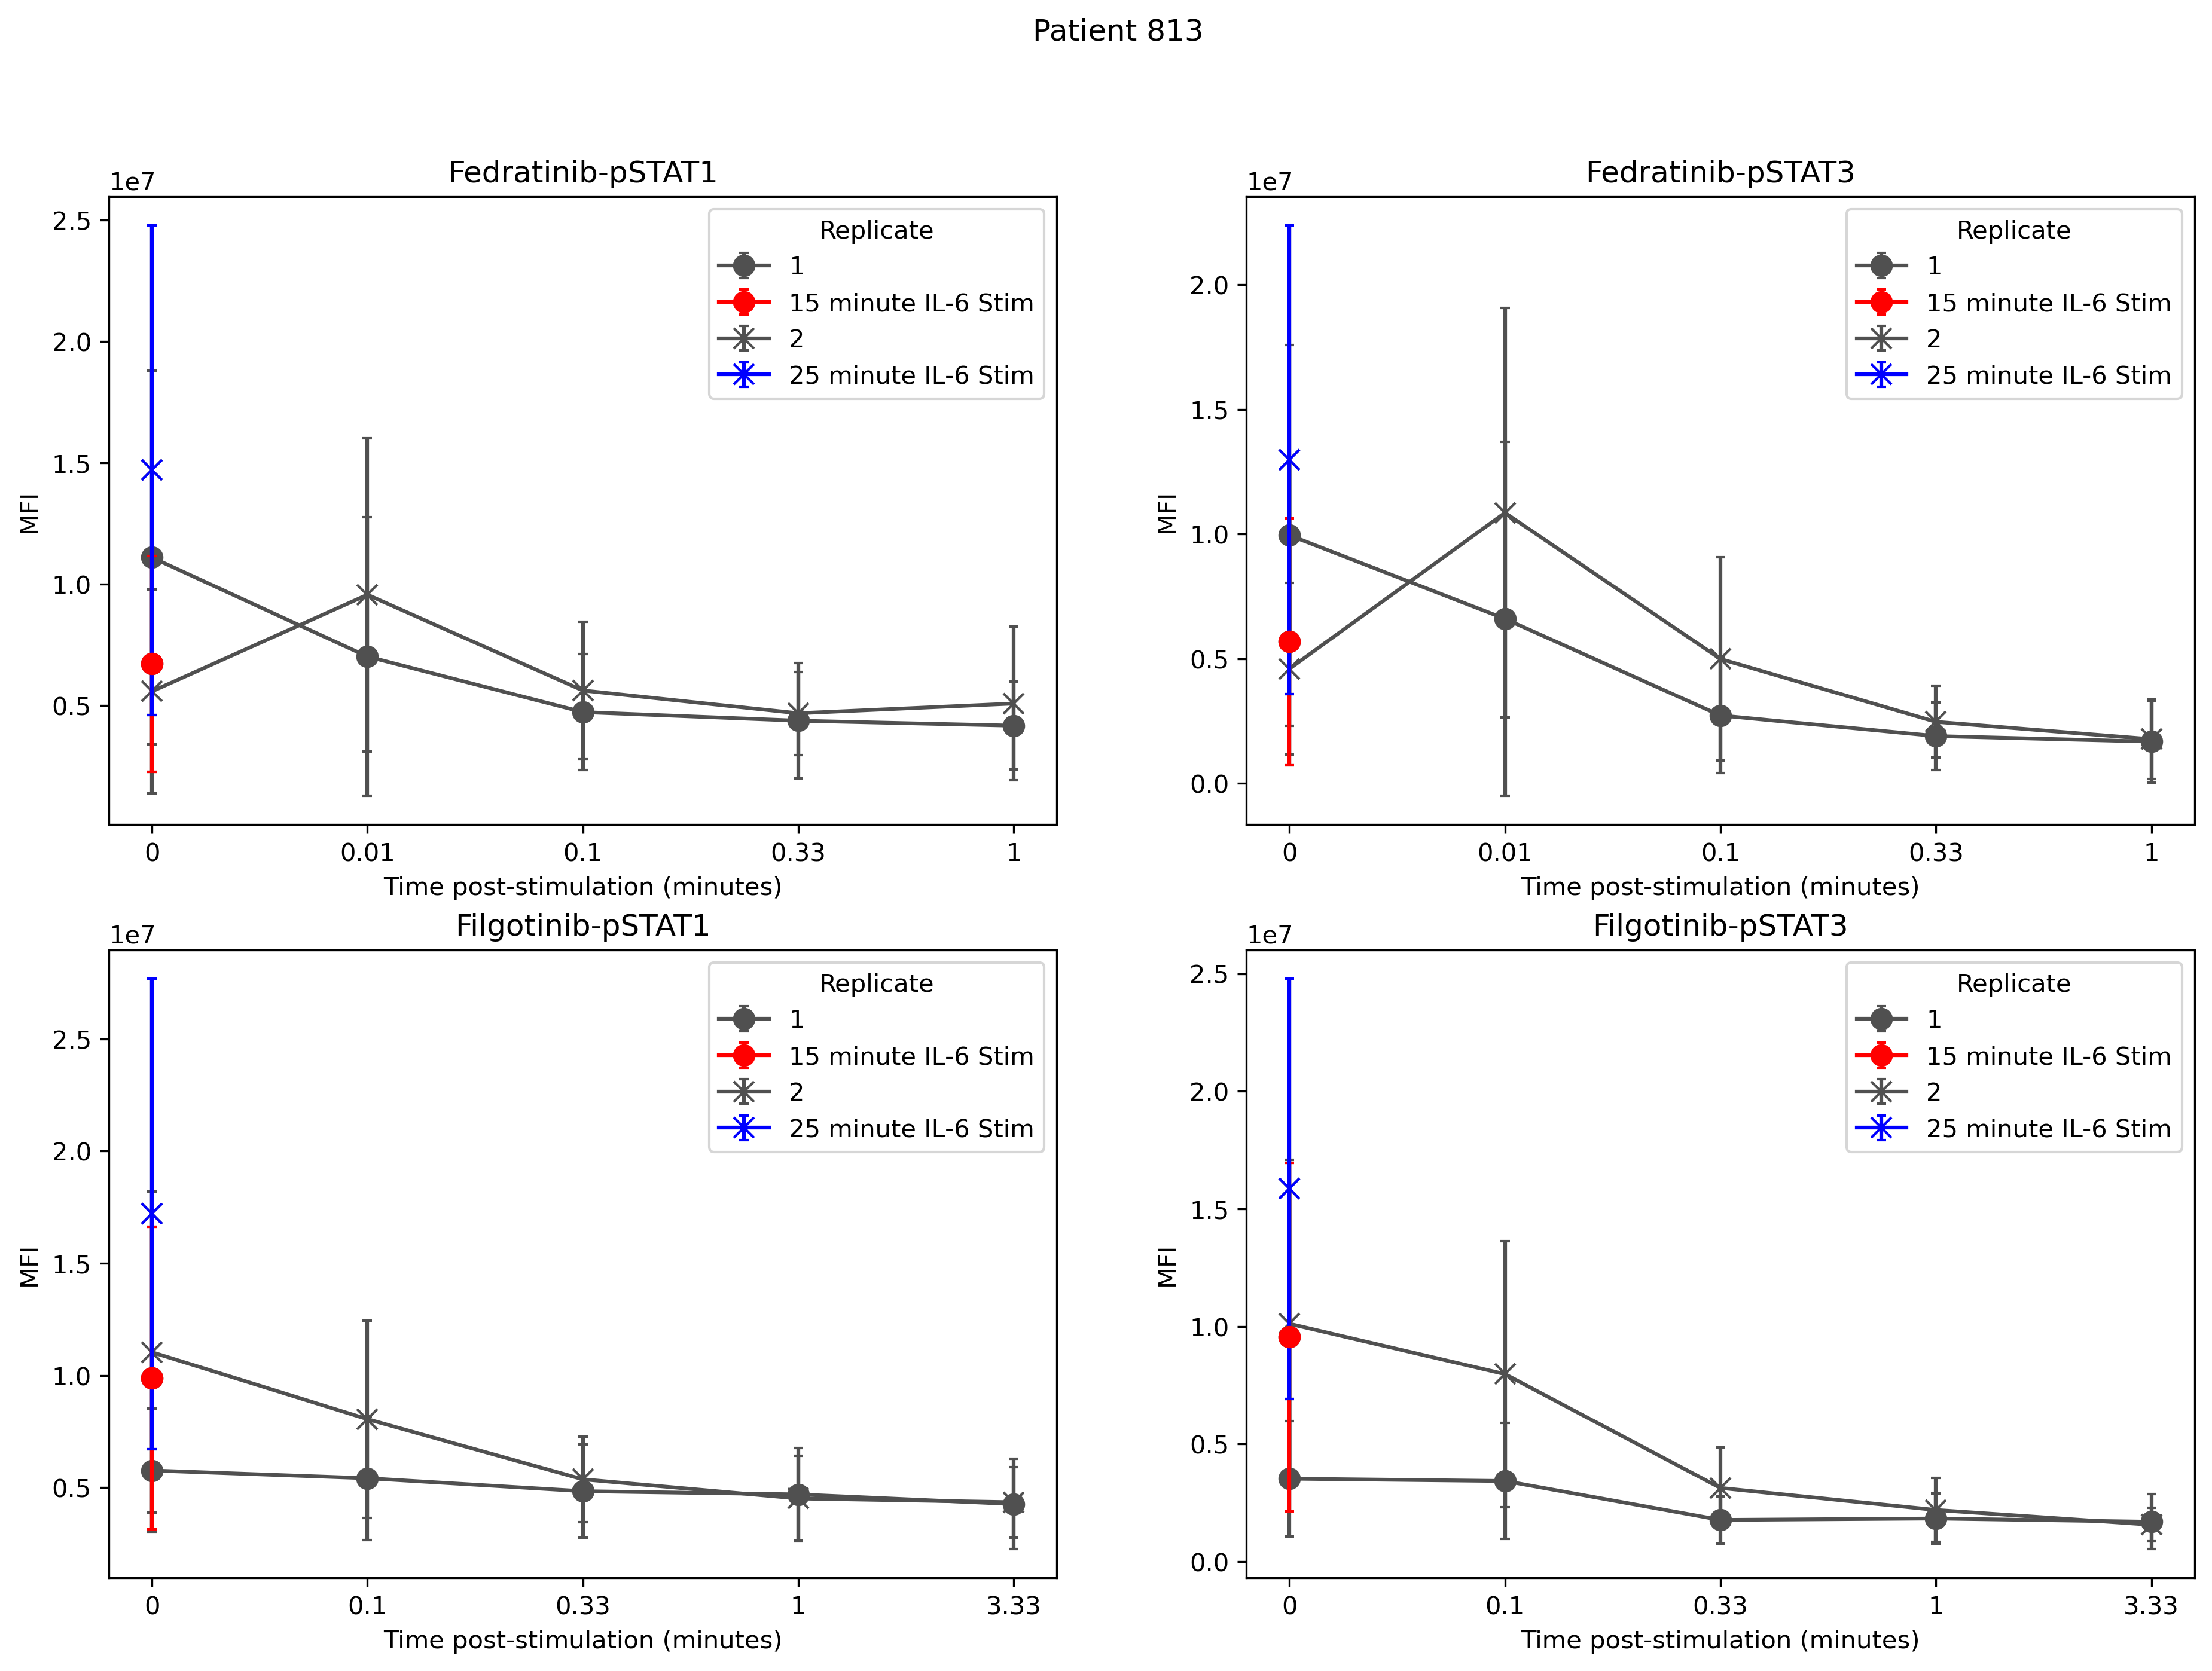

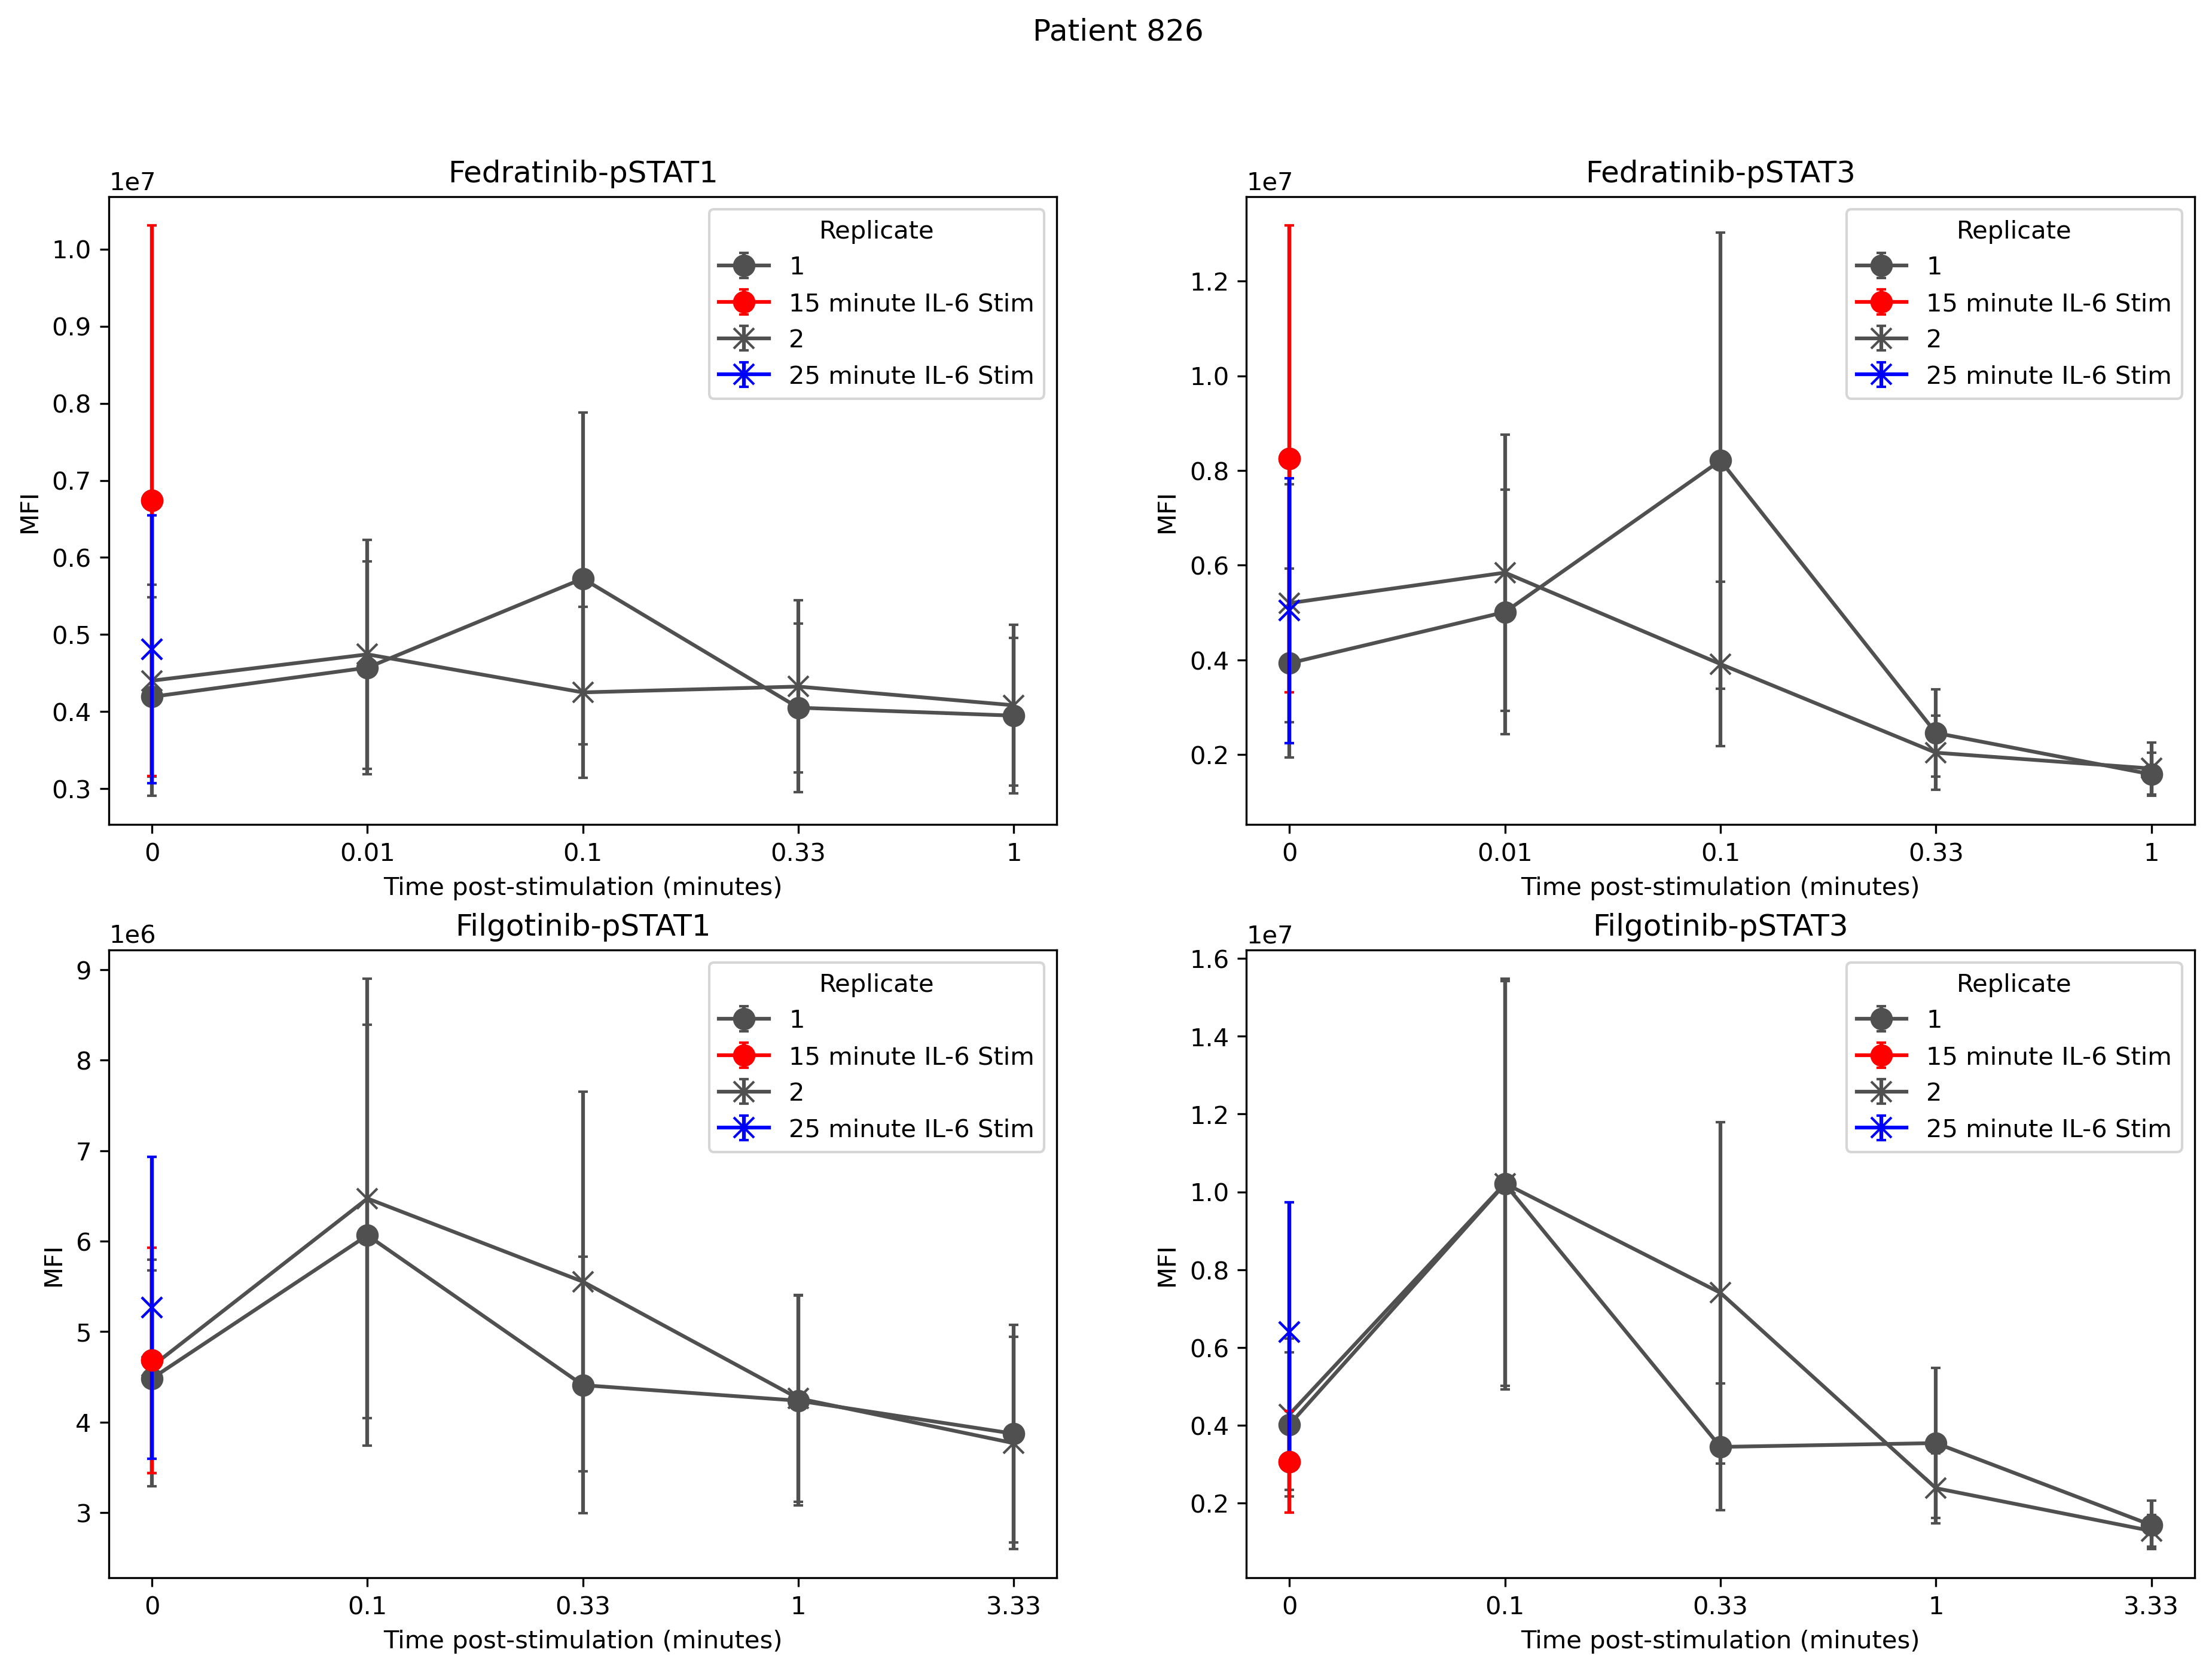

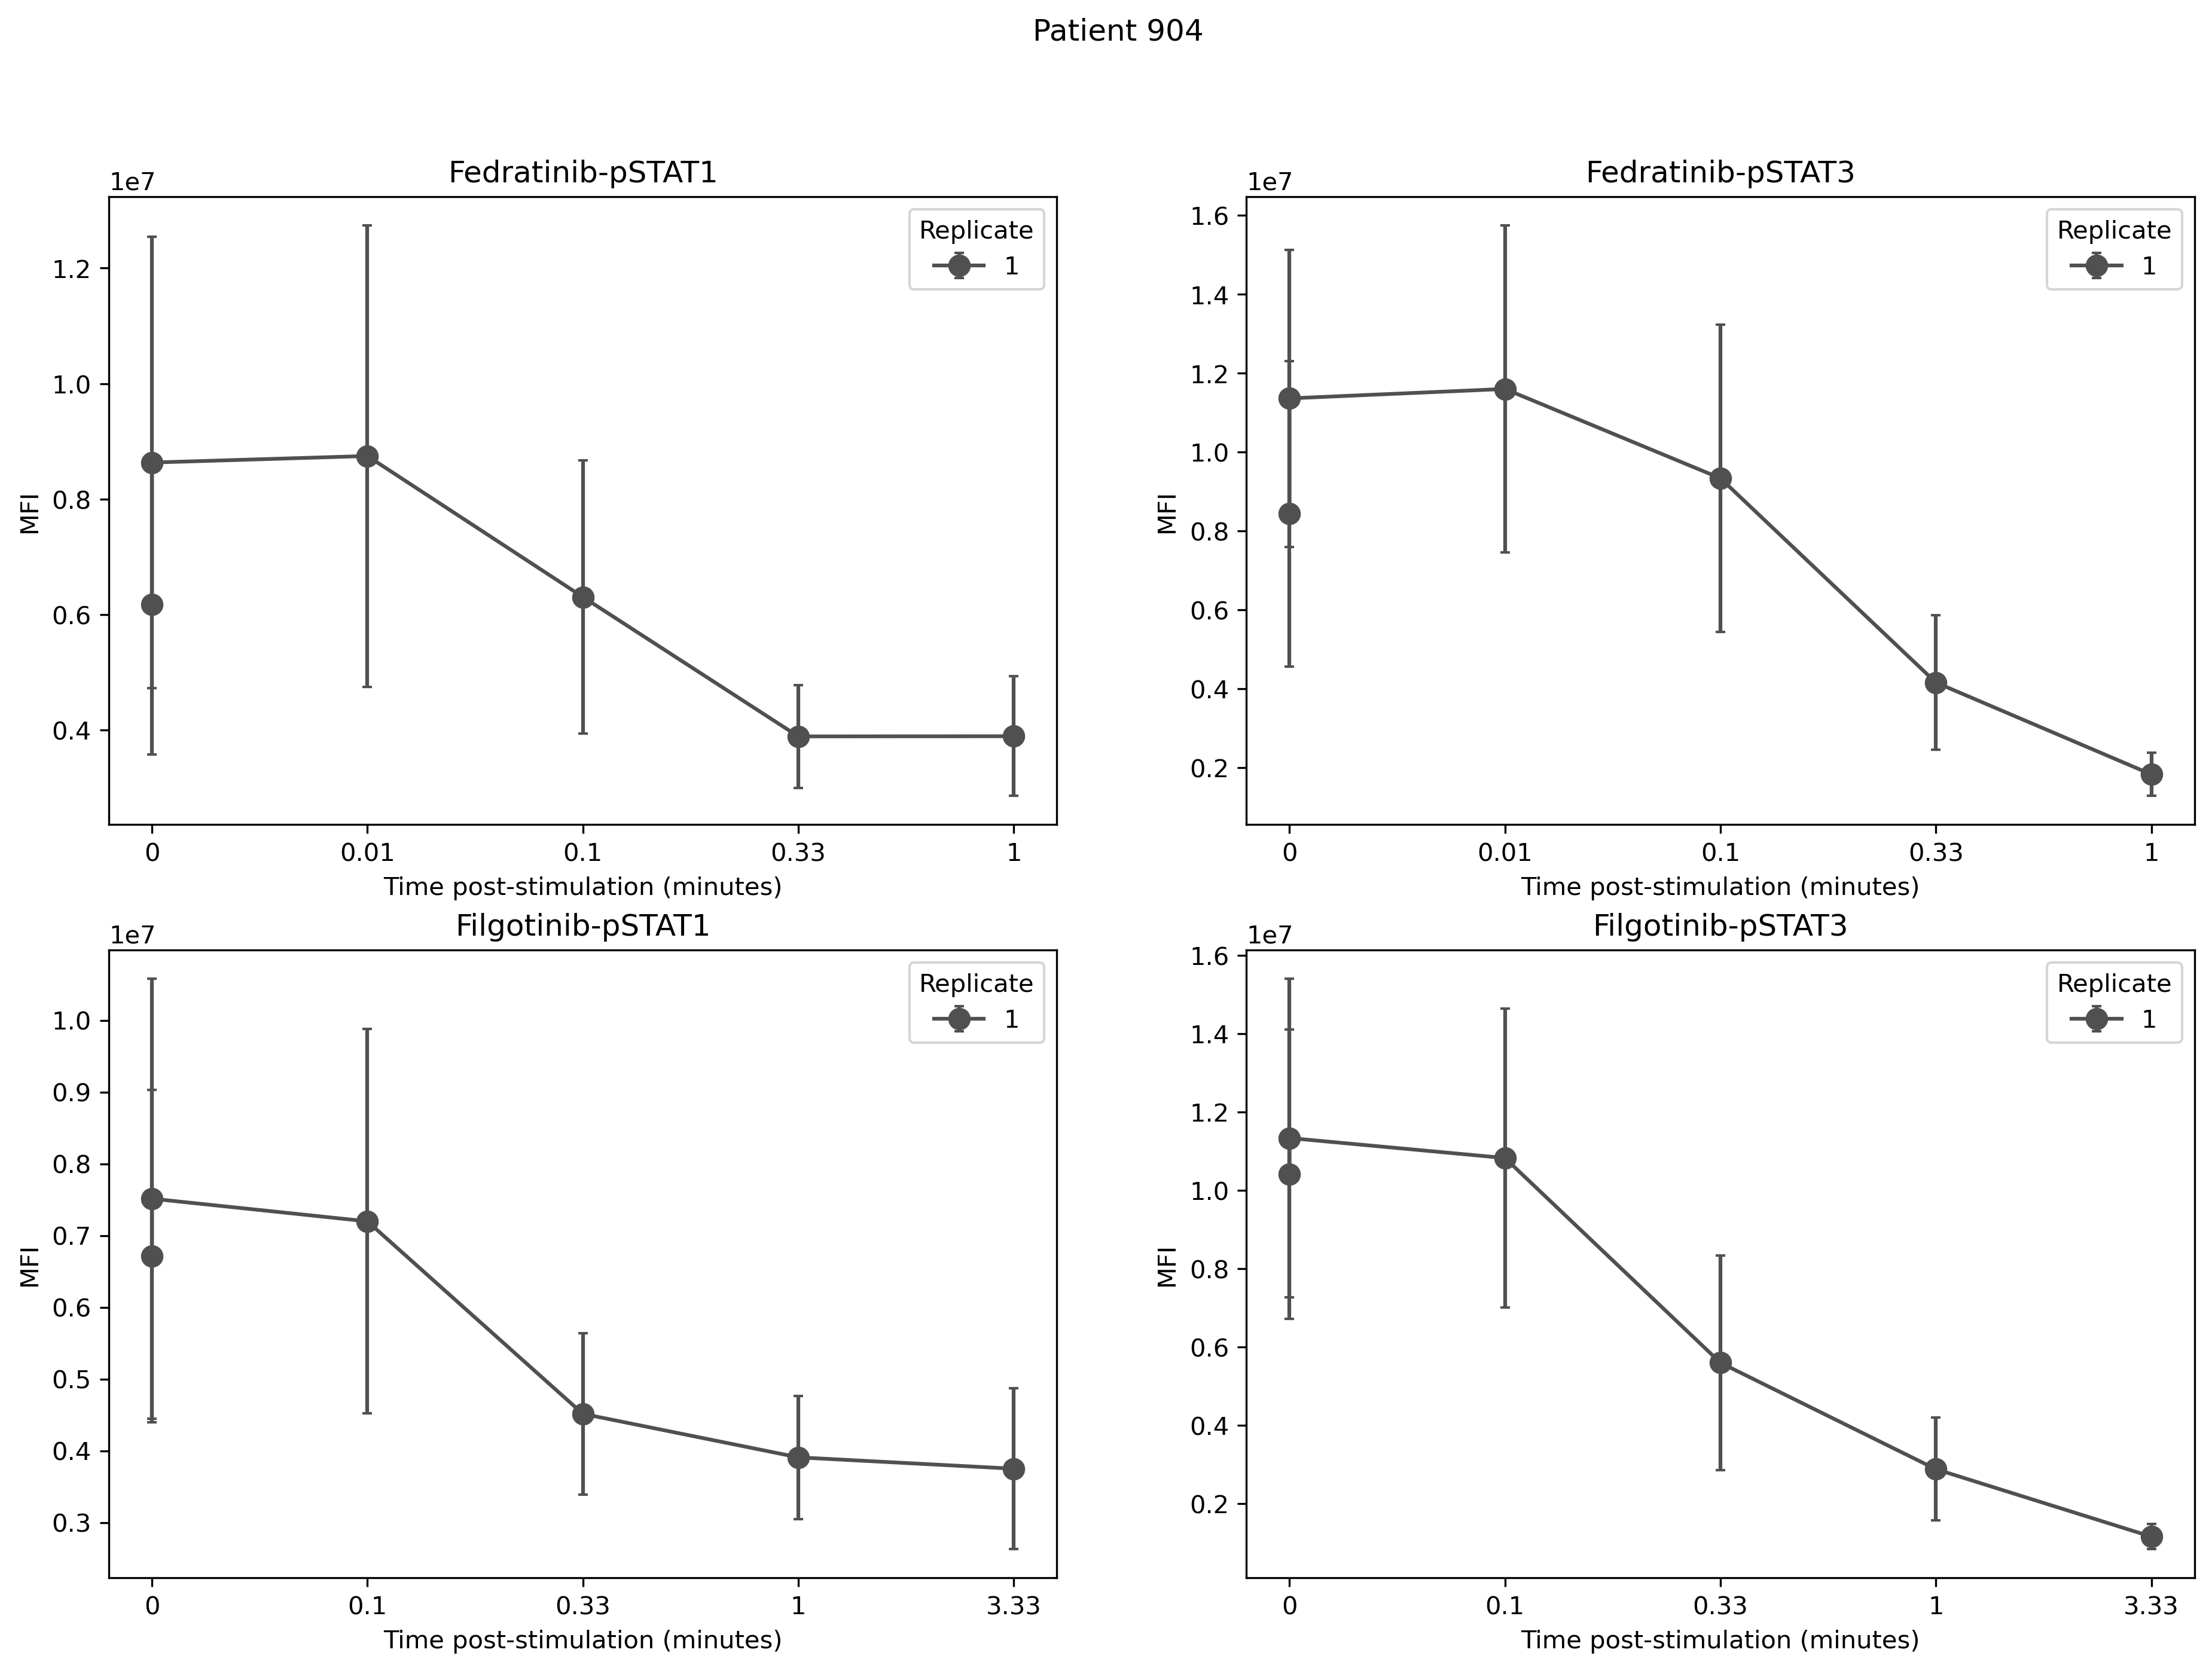

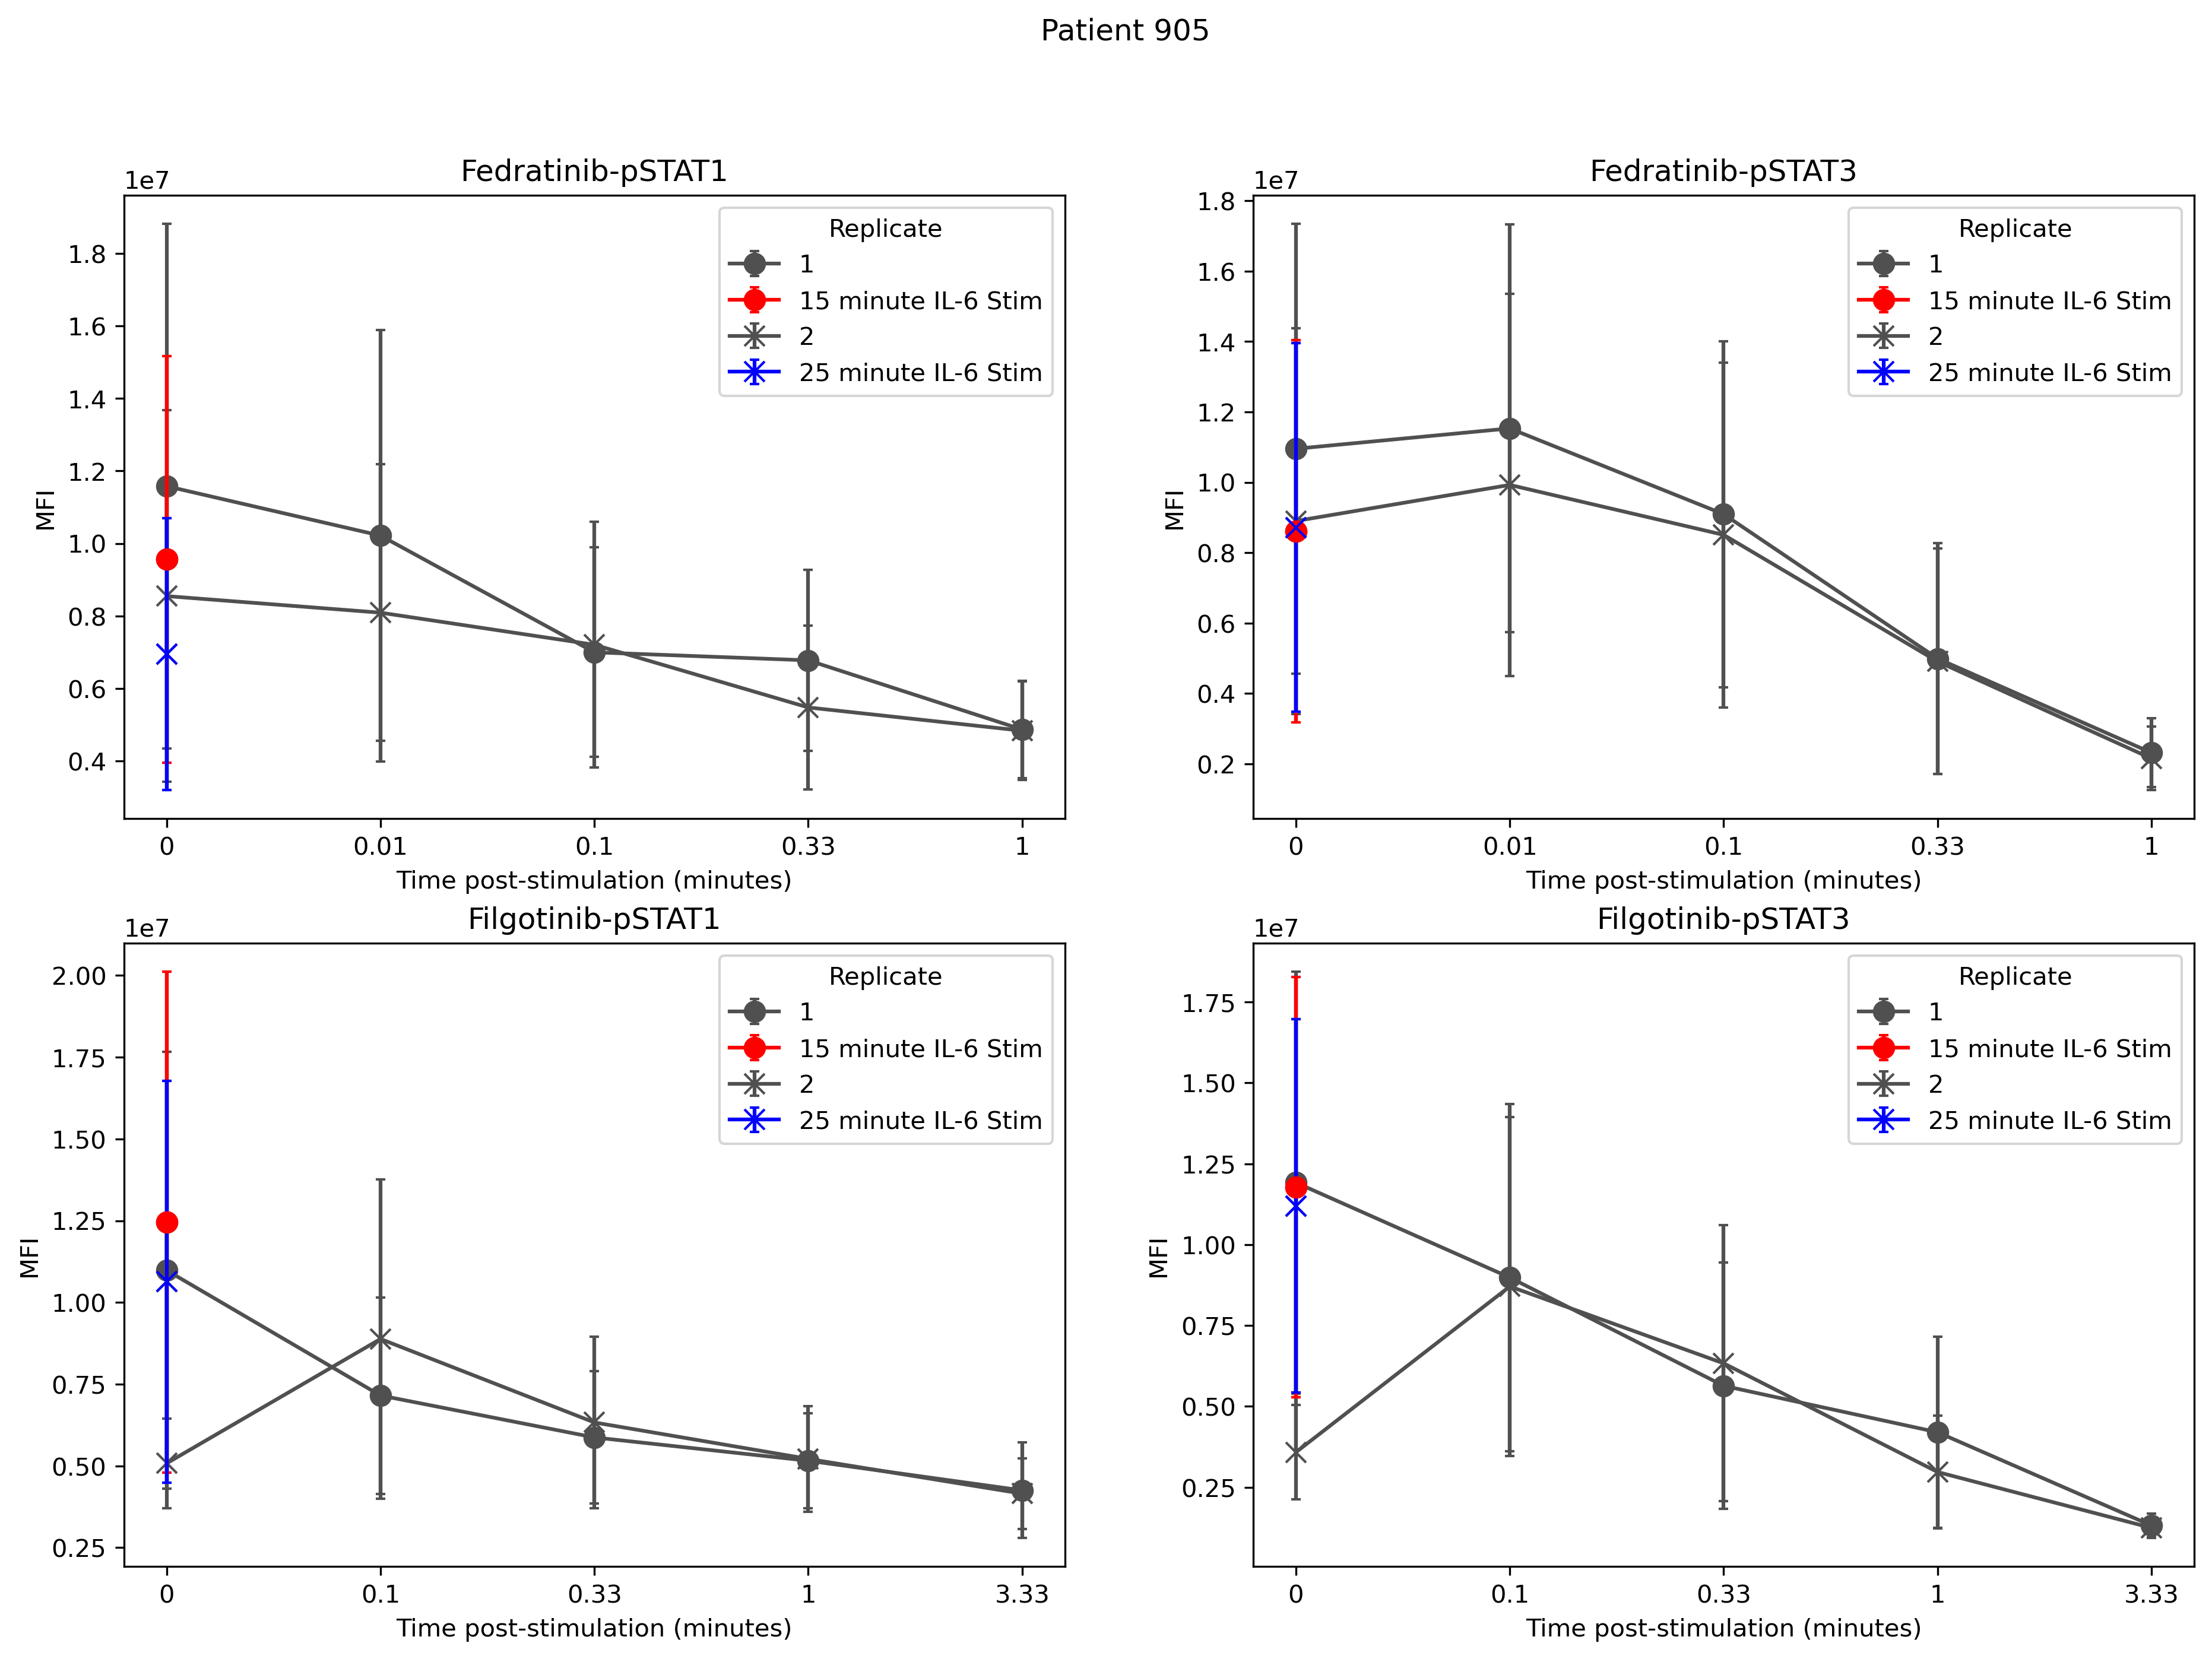

In [27]:
manual_ylim = False

og_df = dfs[0]
dose_to_ls = {
	"10 ng/mL": "-",
	"1 ng/mL": "dotted"
}

dose_to_color = {
	"1 ng/mL": "r",
	"10 ng/mL":"b"
}

il6_to_marker = {
	"1 ng/mL": "d",
	"10 ng/mL": "x"
}

replicate_to_marker = {
	1:"o",
	2:"x",
	3:"v"
}

ms = 8 # markersize
color = "#505050"
fig1, axs1 = plt.subplots(2,2, figsize=(15,10), dpi=300)
fig2, axs2 = plt.subplots(2,2, figsize=(15,10), dpi=300)
fig3, axs3 = plt.subplots(2,2, figsize=(15,10), dpi=300)
fig4, axs4 = plt.subplots(2,2, figsize=(15,10), dpi=300)

# Select tSTAT measurement
df = og_df[(og_df["STAT"] == "Fedra")]

for pat, cur_axs in zip(df["PatientId"].unique(), [axs1, axs2, axs3, axs4]):
	# Plot tSTATs from first scan
	stat1_ax = cur_axs[0][0]
	stat3_ax = cur_axs[0][1]
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		if select_df.empty:
			continue;
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
		if rep == 1 and pat != 904:
			# get the first row 
			special = select_df.iloc[0, :]
			
			stat1_ax.errorbar(special["Time"], special["STAT1 Mean"], yerr=special["STAT1 SEM"], marker=replicate_to_marker[rep], ms=ms, color="red",
					label=f"15 minute IL-6 Stim", capsize=2, zorder=3)
			stat3_ax.errorbar(special["Time"], special["STAT3 Mean"], yerr=special["STAT3 SEM"], marker=replicate_to_marker[rep], ms=ms, color="red",
					label=f"15 minute IL-6 Stim", capsize=2, zorder=3)
		elif rep == 2 and pat != 904:
			# get the first row 
			special = select_df.iloc[0, :]
			
			stat1_ax.errorbar(special["Time"], special["STAT1 Mean"], yerr=special["STAT1 SEM"], marker=replicate_to_marker[rep], ms=ms, color="blue",
					label=f"25 minute IL-6 Stim", capsize=2, zorder=3)
			stat3_ax.errorbar(special["Time"], special["STAT3 Mean"], yerr=special["STAT3 SEM"], marker=replicate_to_marker[rep], ms=ms, color="blue",
					label=f"25 minute IL-6 Stim", capsize=2, zorder=3)
	stat1_ax.set_ylabel("MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Replicate")
	stat1_ax.set_title("Fedratinib-pSTAT1")
	stat3_ax.set_ylabel("MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Replicate")
	stat3_ax.set_title("Fedratinib-pSTAT3")


# Select pSTAT measurement
df = og_df[og_df["STAT"] == "Filgo"]

for pat, cur_axs in zip(df["PatientId"].unique(), [axs1, axs2, axs3, axs4]):
	# Plot tSTATs from first scan
	stat1_ax = cur_axs[1][0]
	stat3_ax = cur_axs[1][1]
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"] == rep)]
		if select_df.empty:
			continue
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)

		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
		print(f"Patient {pat}, Rep {rep}")
		if rep == 1 and pat != 904:
			# get the first row 
			special = select_df.iloc[0, :]
			
			stat1_ax.errorbar(special["Time"], special["STAT1 Mean"], yerr=special["STAT1 SEM"], marker=replicate_to_marker[rep], ms=ms, color="red",
					label=f"15 minute IL-6 Stim", capsize=2, zorder=3)
			stat3_ax.errorbar(special["Time"], special["STAT3 Mean"], yerr=special["STAT3 SEM"], marker=replicate_to_marker[rep], ms=ms, color="red",
					label=f"15 minute IL-6 Stim", capsize=2, zorder=3)
		elif rep == 2 and pat != 904:
			# get the first row 
			special = select_df.iloc[0, :]
			
			stat1_ax.errorbar(special["Time"], special["STAT1 Mean"], yerr=special["STAT1 SEM"], marker=replicate_to_marker[rep], ms=ms, color="blue",
					label=f"25 minute IL-6 Stim", capsize=2, zorder=3)
			stat3_ax.errorbar(special["Time"], special["STAT3 Mean"], yerr=special["STAT3 SEM"], marker=replicate_to_marker[rep], ms=ms, color="blue",
					label=f"25 minute IL-6 Stim", capsize=2, zorder=3)
	stat1_ax.set_ylabel("MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Replicate")
	stat1_ax.set_title("Filgotinib-pSTAT1")
	stat3_ax.set_ylabel("MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Replicate")
	stat3_ax.set_title("Filgotinib-pSTAT3")


id1 = df["PatientId"].unique()[0]
id2 = df["PatientId"].unique()[1]
id3 = df["PatientId"].unique()[2]
id4 = df["PatientId"].unique()[3]

fig1.suptitle(f"Patient {id1}")
fig2.suptitle(f"Patient {id2}");
fig3.suptitle(f"Patient {id3}")
fig4.suptitle(f"Patient {id4}")

KeyError: np.int64(826)

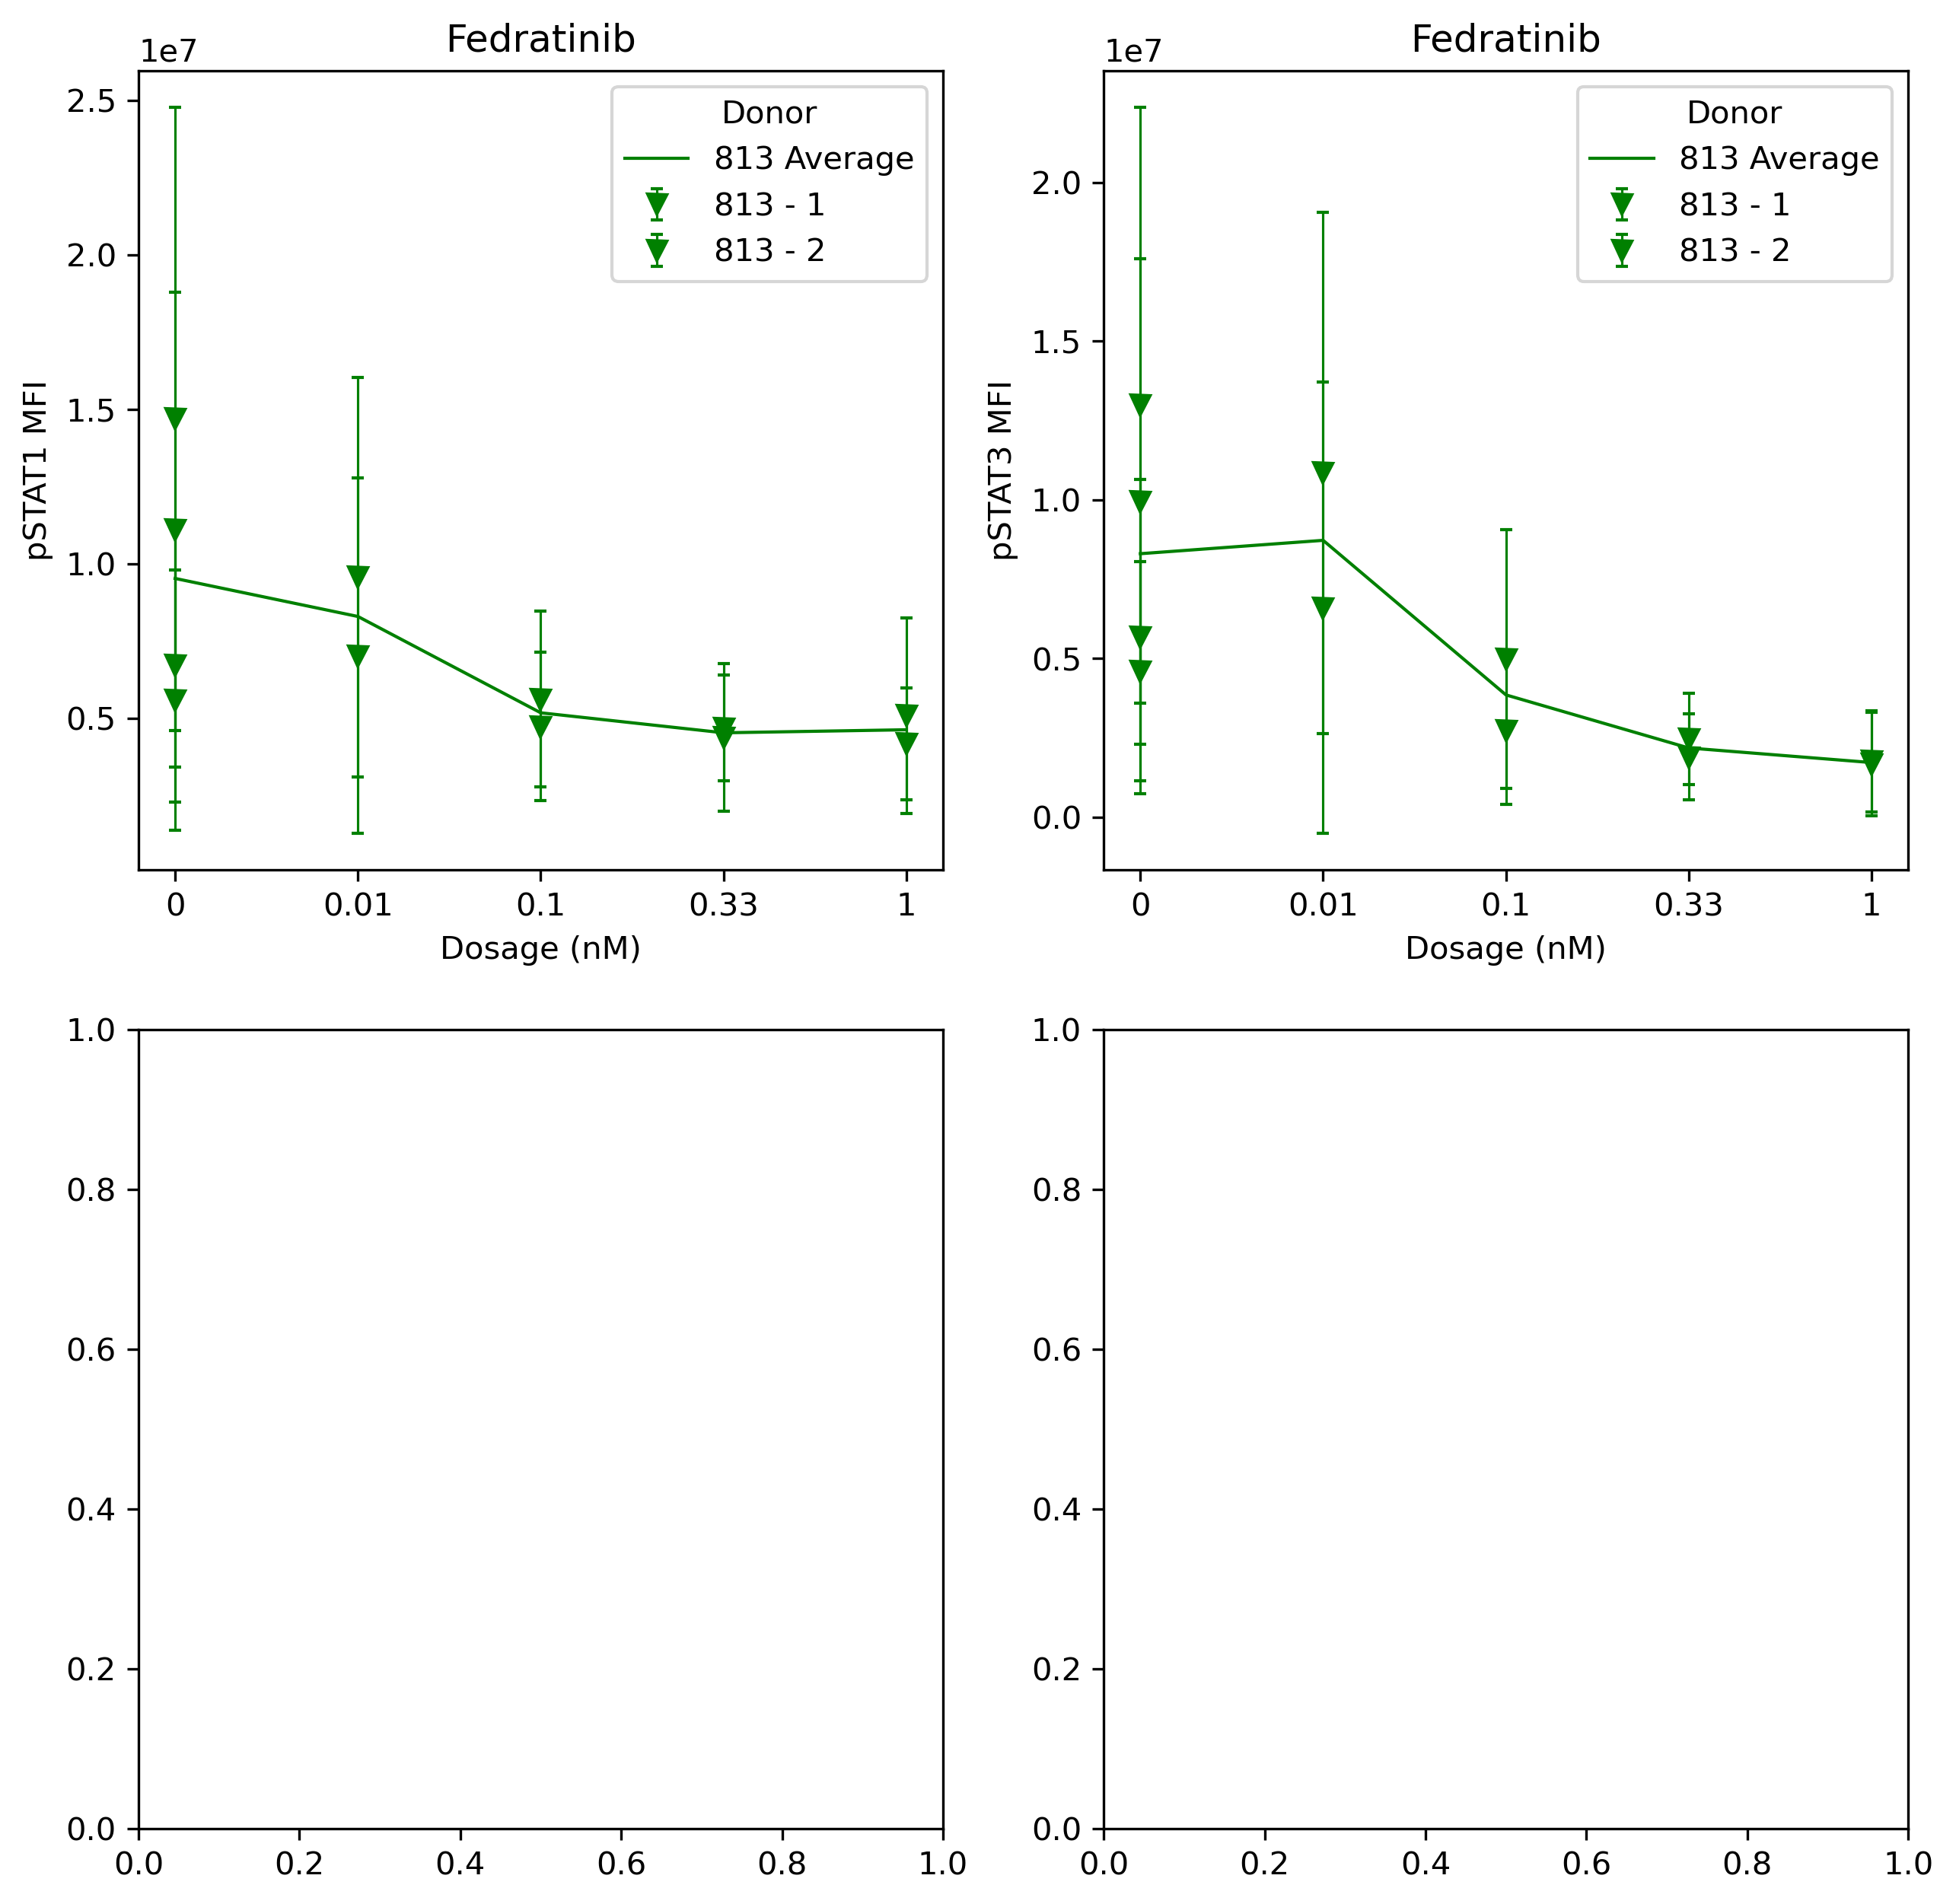

In [16]:
og_df = dfs[0]


patient_to_color = {
	617: "r",
	626: "b",
    813: "g"
}


patient_to_marker = {
	617:"o",
	626:"x",
	813:"v"
}

ms = 6 # markersize
fig1, axs = plt.subplots(2,2, figsize=(10,10), dpi=300)

# Select tSTAT measurement
df = og_df[(og_df["STAT"] == "Fedra")]

for pat in df["PatientId"].unique():
	# Plot tSTATs from first scan
	stat1_ax = axs[0][0]
	stat3_ax = axs[0][1]
 
	cur_df = df.loc[df["PatientId"] == pat]

	stat1_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT1 Mean"].mean(),
					marker="none", color=patient_to_color[pat], 
     				lw=1, label=f"{pat} Average")

	stat3_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT3 Mean"].mean(),
					marker="none", color=patient_to_color[pat], 
     				lw=1, label=f"{pat} Average")
 
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		if select_df.empty:
			continue
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none",
     				lw=0.75, label=f"{pat} - {rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none", 
     				lw=0.75,  label=f"{pat} - {rep}", capsize=2)
	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.set_xlabel("Dosage (nM)")
	stat1_ax.legend(title="Donor")
	stat1_ax.set_title("Fedratinib")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Dosage (nM)")
	stat3_ax.legend(title="Donor")
	stat3_ax.set_title("Fedratinib")
 
# Select tSTAT measurement
df = og_df[(og_df["STAT"] == "Filgo")]

for pat in df["PatientId"].unique():
	# Plot tSTATs from first scan
	stat1_ax = axs[1][0]
	stat3_ax = axs[1][1]

	cur_df = df.loc[df["PatientId"] == pat]

	stat1_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT1 Mean"].mean(),
					marker="none", color=patient_to_color[pat], 
     				lw=1, label=f"{pat} Average")

	stat3_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT3 Mean"].mean(),
					marker="none", color=patient_to_color[pat], 
     				lw=1, label=f"{pat} Average")
 
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		if select_df.empty:
			continue
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none", 
     				lw=0.75, label=f"{pat} - {rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none", 
     				lw=0.75, label=f"{pat} - {rep}", capsize=2)
	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.set_xlabel("Dosage (nM)")
	stat1_ax.legend(title="Donor")
	stat1_ax.set_title("Filgotinib")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Dosage (nM)")
	stat3_ax.legend(title="Donor")
	stat3_ax.set_title("Filgotinib")
